In [1]:
# Friday 8th September 2023


In [2]:
import os
import cv2
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import imantics
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split
%matplotlib inline

2023-09-08 21:21:03.841646: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-08 21:21:04.583222: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
IMG_SIZE = 512
DEVICE = "cuda"
BATCH_SIZE = 8
LR = 0.003
EPOCHS = 5  # no improvement after 19


In [4]:
import os

images_dir = "dataset/Google_maps/train/images"
masks_dir = "dataset/Google_maps/train/label"


# Initialize lists to store file paths
train_images_listdir = []
train_masks_listdir = []

# Collect image file paths and sort them numerically
image_files = sorted(os.listdir(images_dir), key=lambda x: int(x.split(".")[0]))
for image_file in image_files:
    if image_file.endswith(".jpg"):
        train_images_listdir.append(os.path.join(images_dir, image_file))

# Collect mask file paths and sort them numerically
mask_files = sorted(os.listdir(masks_dir), key=lambda x: int(x.split(".")[0]))
for mask_file in mask_files:
    if mask_file.endswith(".jpg"):
        train_masks_listdir.append(os.path.join(masks_dir, mask_file))

# Create a DataFrame
df = pd.DataFrame({"images": train_images_listdir, "masks": train_masks_listdir})


In [5]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=66)


In [6]:
idx = 12

row = train_df.iloc[idx]

image_path = row.images
image = cv2.imread(image_path)

mask_path = row.masks
mask = cv2.imread(mask_path)


In [7]:
def show(image, mask):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.set_title("IMAGE:")
    ax1.imshow(image)

    ax2.set_title("GROUND TRUTH:")
    ax2.imshow(mask)


In [8]:
def read_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


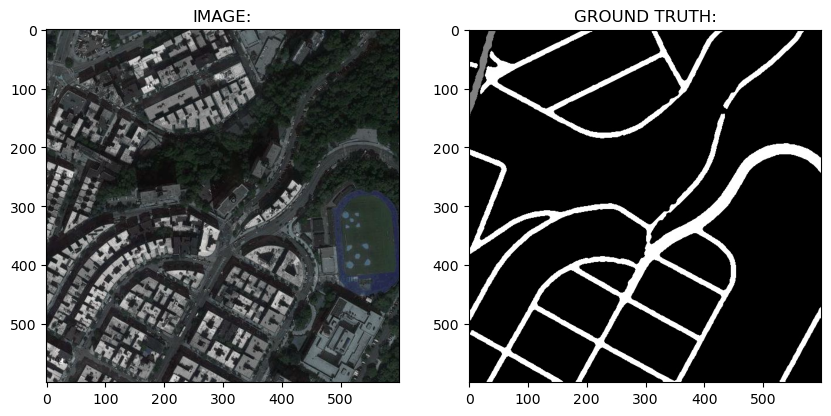

In [9]:
show(image, mask)


# Augmentations


In [10]:
import albumentations as A

# In segmentation the mask should also rotate if the image rotates, not the same as in classification.


def get_train_augments():
    image_augments = A.Compose(
        [A.Resize(IMG_SIZE, IMG_SIZE), A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5)],
        additional_targets={"mask": "image"},
    )

    mask_augments = A.Compose(
        [A.Resize(IMG_SIZE, IMG_SIZE), A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5)],
        additional_targets={"image": "mask"},
    )

    return A.Compose([image_augments, mask_augments])


def get_val_augments():
    return A.Compose([A.Resize(IMG_SIZE, IMG_SIZE)])


# DataLoader

In [11]:
from torch.utils.data import Dataset
import torch


class SegmentationDataset(Dataset):
    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        image_path = row.images
        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)  # In HWC

        mask_path = row.masks
        mask = cv2.resize(
            cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2GRAY),
            (image.shape[1], image.shape[0]),
        )  # extra channel width for h,w,c
        mask = np.expand_dims(mask, axis=-1)

        """ print(f"Image shape before augmentation: {image.shape}")
        print(f"Mask shape before augmentation: {mask.shape}")"""

        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data["image"]
            mask = data["mask"]

        """print(f"Image shape after augmentation: {image.shape}")
        print(f"Mask shape after augmentation: {mask.shape}")"""

        # Ensure the dimensions are the same for image and mask
        if image.shape[:2] != mask.shape[:2]:
            raise ValueError("Image and mask dimensions do not match.")

        # Pytorch uses channel height width convention so we gotta change
        image = (
            torch.Tensor(np.transpose(image, (2, 0, 1)).astype(np.float32)) / 255.0
        )  # C W H, convention, below too
        mask = torch.Tensor(np.transpose(mask, (2, 0, 1)).astype(np.float32)) / 255.0

        return image, mask


In [12]:
train_set = SegmentationDataset(train_df, get_train_augments())
valid_set = SegmentationDataset(valid_df, get_val_augments())


In [13]:
print(f"Size of train set: {len(train_set)}\n Size of validation set: {len(valid_set)}")


Size of train set: 826
 Size of validation set: 207


In [14]:
def show2(image, mask, pred_mask):
    if pred_mask != None:
        fig, axes = plt.subplots(1, 3, figsize=(10, 5))
        # Display the mask
        axes[2].imshow(
            mask.squeeze(), cmap="gray"
        )  # Remove the channel dimension for grayscale
        axes[2].set_title("Model Output Mask:")
    else:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    image = image.permute(1, 2, 0)
    mask = mask.permute(1, 2, 0)  # Convert CWH to HWC for display

    # Display the image
    axes[0].imshow(image)
    axes[0].set_title("Image")

    # Display the mask
    axes[1].imshow(
        mask.squeeze(), cmap="gray"
    )  # Remove the channel dimension for grayscale
    axes[1].set_title("Mask")

    plt.show()


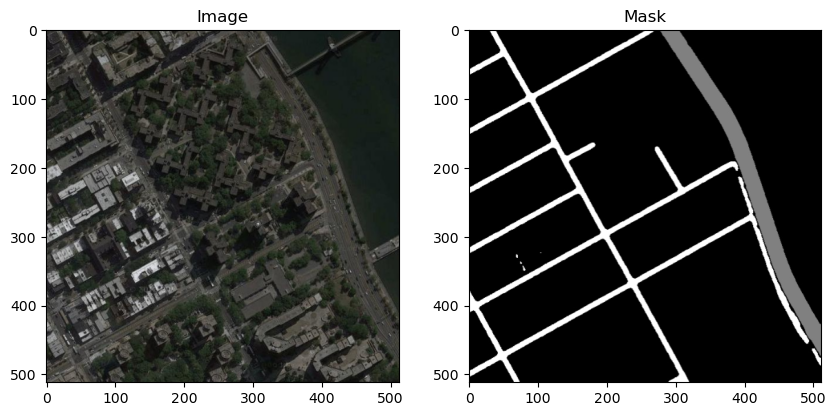

In [15]:
idx = 4
image, mask = train_set[idx]
show2(image, mask, None)


# Dataloader

In [16]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=False)


In [17]:
print(f"Train batches created: {len(train_loader)}")
print(f"Validation batches created: {len(valid_loader)}")


Train batches created: 104
Validation batches created: 26


In [18]:
for images, masks in train_loader:
    print(f"One batch image shape: {images.shape, masks.shape}")
    break


One batch image shape: (torch.Size([8, 3, 512, 512]), torch.Size([8, 1, 512, 512]))


# UNET Segementation Model

In [19]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from torch import nn


/home/kalamari/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.backbone = smp.Unet(
            encoder_name="timm-efficientnet-b0",
            encoder_weights="imagenet",
            in_channels=3,
            classes=1,
            activation=None,
        )

    def forward(self, images, masks=None):
        logits = self.backbone(images)

        if masks != None:
            return logits, DiceLoss(mode="binary")(
                logits, masks
            ) + nn.BCEWithLogitsLoss()(logits, masks)

        return logits


In [21]:
model = SegmentationModel()
model.to(DEVICE)


# Train Val Functions

In [22]:
from tqdm import tqdm


In [23]:
def train_fn(dataloader, model, optimizer):
    model.train()  # turn on dropout, batchnorm, etc, grads

    total_loss = 0.0

    for images, masks in tqdm(dataloader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def eval_fn(dataloader, model):
    model.eval()  # turn off dropout, batchnorm, etc, grads

    total_loss = 0.0

    with torch.no_grad():
        for images, masks in tqdm(dataloader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)

            total_loss += loss.item()

        return total_loss / len(dataloader)


# Training

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


In [25]:
best_loss = np.Inf

for i in range(EPOCHS):
    train_loss = train_fn(train_loader, model, optimizer)
    valid_loss = eval_fn(valid_loader, model)

    if valid_loss < best_loss:
        torch.save(model.state_dict(), "best_segmentation_model2.pt")
        print(f"Model has been saved.")

        best_loss = valid_loss

    print(f"Epoch: {i+1} Train Loss: {train_loss} Validation Loss: {valid_loss}")


100%|██████████| 26/26 [00:04<00:00,  5.80it/s]


Model has been saved.
Epoch: 1 Train Loss: 0.8312113462732389 Validation Loss: 0.6268959779005784


100%|██████████| 26/26 [00:03<00:00,  7.74it/s]


Model has been saved.
Epoch: 2 Train Loss: 0.5957180556769555 Validation Loss: 0.567546838751206


100%|██████████| 26/26 [00:03<00:00,  7.74it/s]


Model has been saved.
Epoch: 3 Train Loss: 0.5427192077040672 Validation Loss: 0.5405803311329621


100%|██████████| 26/26 [00:03<00:00,  7.83it/s]


Model has been saved.
Epoch: 4 Train Loss: 0.515715632874232 Validation Loss: 0.5278636790238894


100%|██████████| 26/26 [00:03<00:00,  7.77it/s]

Model has been saved.
Epoch: 5 Train Loss: 0.4975927337430991 Validation Loss: 0.49132056534290314


In [29]:
from torchvision import transforms

idx = 4
model.load_state_dict(torch.load("best_segmentation_model2.pt"))

image, mask = valid_set[idx]


In [30]:
logits_mask = model(image.to(DEVICE).unsqueeze(0))  # c h w, model wants b c h w
pred_mask = torch.sigmoid(logits_mask)

pred_mask = (pred_mask > 0.5) * 1.0


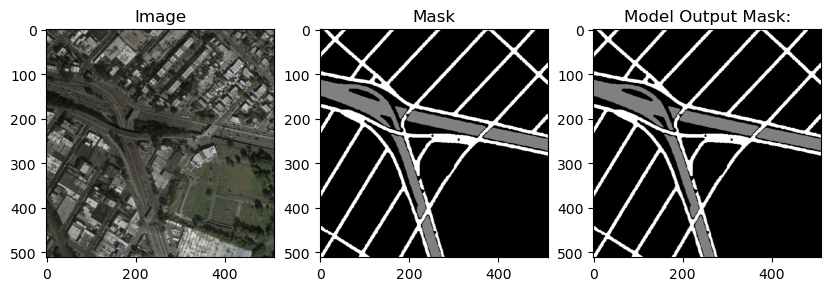

In [31]:
show2(image, mask, pred_mask.detach().cpu().squeeze(0))
